### IMPORTING REQUIRED MODULES

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split


from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#model=LogisticRegression()
#model.fit(X_train,Y_train)

%matplotlib inline

##### SETTING THE GRAPHS SIZE

In [2]:
plt.rcParams['figure.dpi'] = 200
sns.set(rc={'axes.facecolor': '#f9f9f7'}, style='darkgrid')

###  READING THE DATASET AND MAKING A DATAFRAME 

In [3]:
df = pd.read_csv("cb_test.csv")
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
0,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,31,1,1,199,0,0,2,136,0,5.3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,1,2,139,349,0,2,183,1,5.6,2,2,1
996,47,1,3,143,258,1,1,98,1,5.7,1,0,0
997,69,1,0,156,434,1,0,196,0,1.4,3,1,1
998,45,1,1,186,417,0,1,117,1,5.9,3,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1000 non-null   int64  
 1   sex       1000 non-null   int64  
 2   cp        1000 non-null   int64  
 3   trestbps  1000 non-null   int64  
 4   chol      1000 non-null   int64  
 5   fbs       1000 non-null   int64  
 6   restecg   1000 non-null   int64  
 7   thalach   1000 non-null   int64  
 8   exang     1000 non-null   int64  
 9   oldpeak   1000 non-null   float64
 10  slope     1000 non-null   int64  
 11  ca        1000 non-null   int64  
 12  target    1000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 101.7 KB


### DECLARING CONTINUOUS FEATURES

In [5]:
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert] = df[features_to_convert].astype('object')
df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
target       object
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1000.0,49.2420,17.864730,20.0,34.00,49.0,64.25,80.0
trestbps,1000.0,151.7470,29.965228,94.0,129.00,147.0,181.00,200.0
chol,1000.0,311.4470,132.443801,0.0,235.75,318.0,404.25,602.0
thalach,1000.0,145.4770,34.190268,71.0,119.75,146.0,175.00,202.0
oldpeak,1000.0,2.7077,1.720753,0.0,1.30,2.4,4.10,6.2


In [7]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,target
count,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,4,2,3,2,4,4,2
top,1,0,0,0,0,2,1,1
freq,765,420,704,454,502,322,344,580


### FILTERING CF FOR UNIVARIATE ANALYSIS

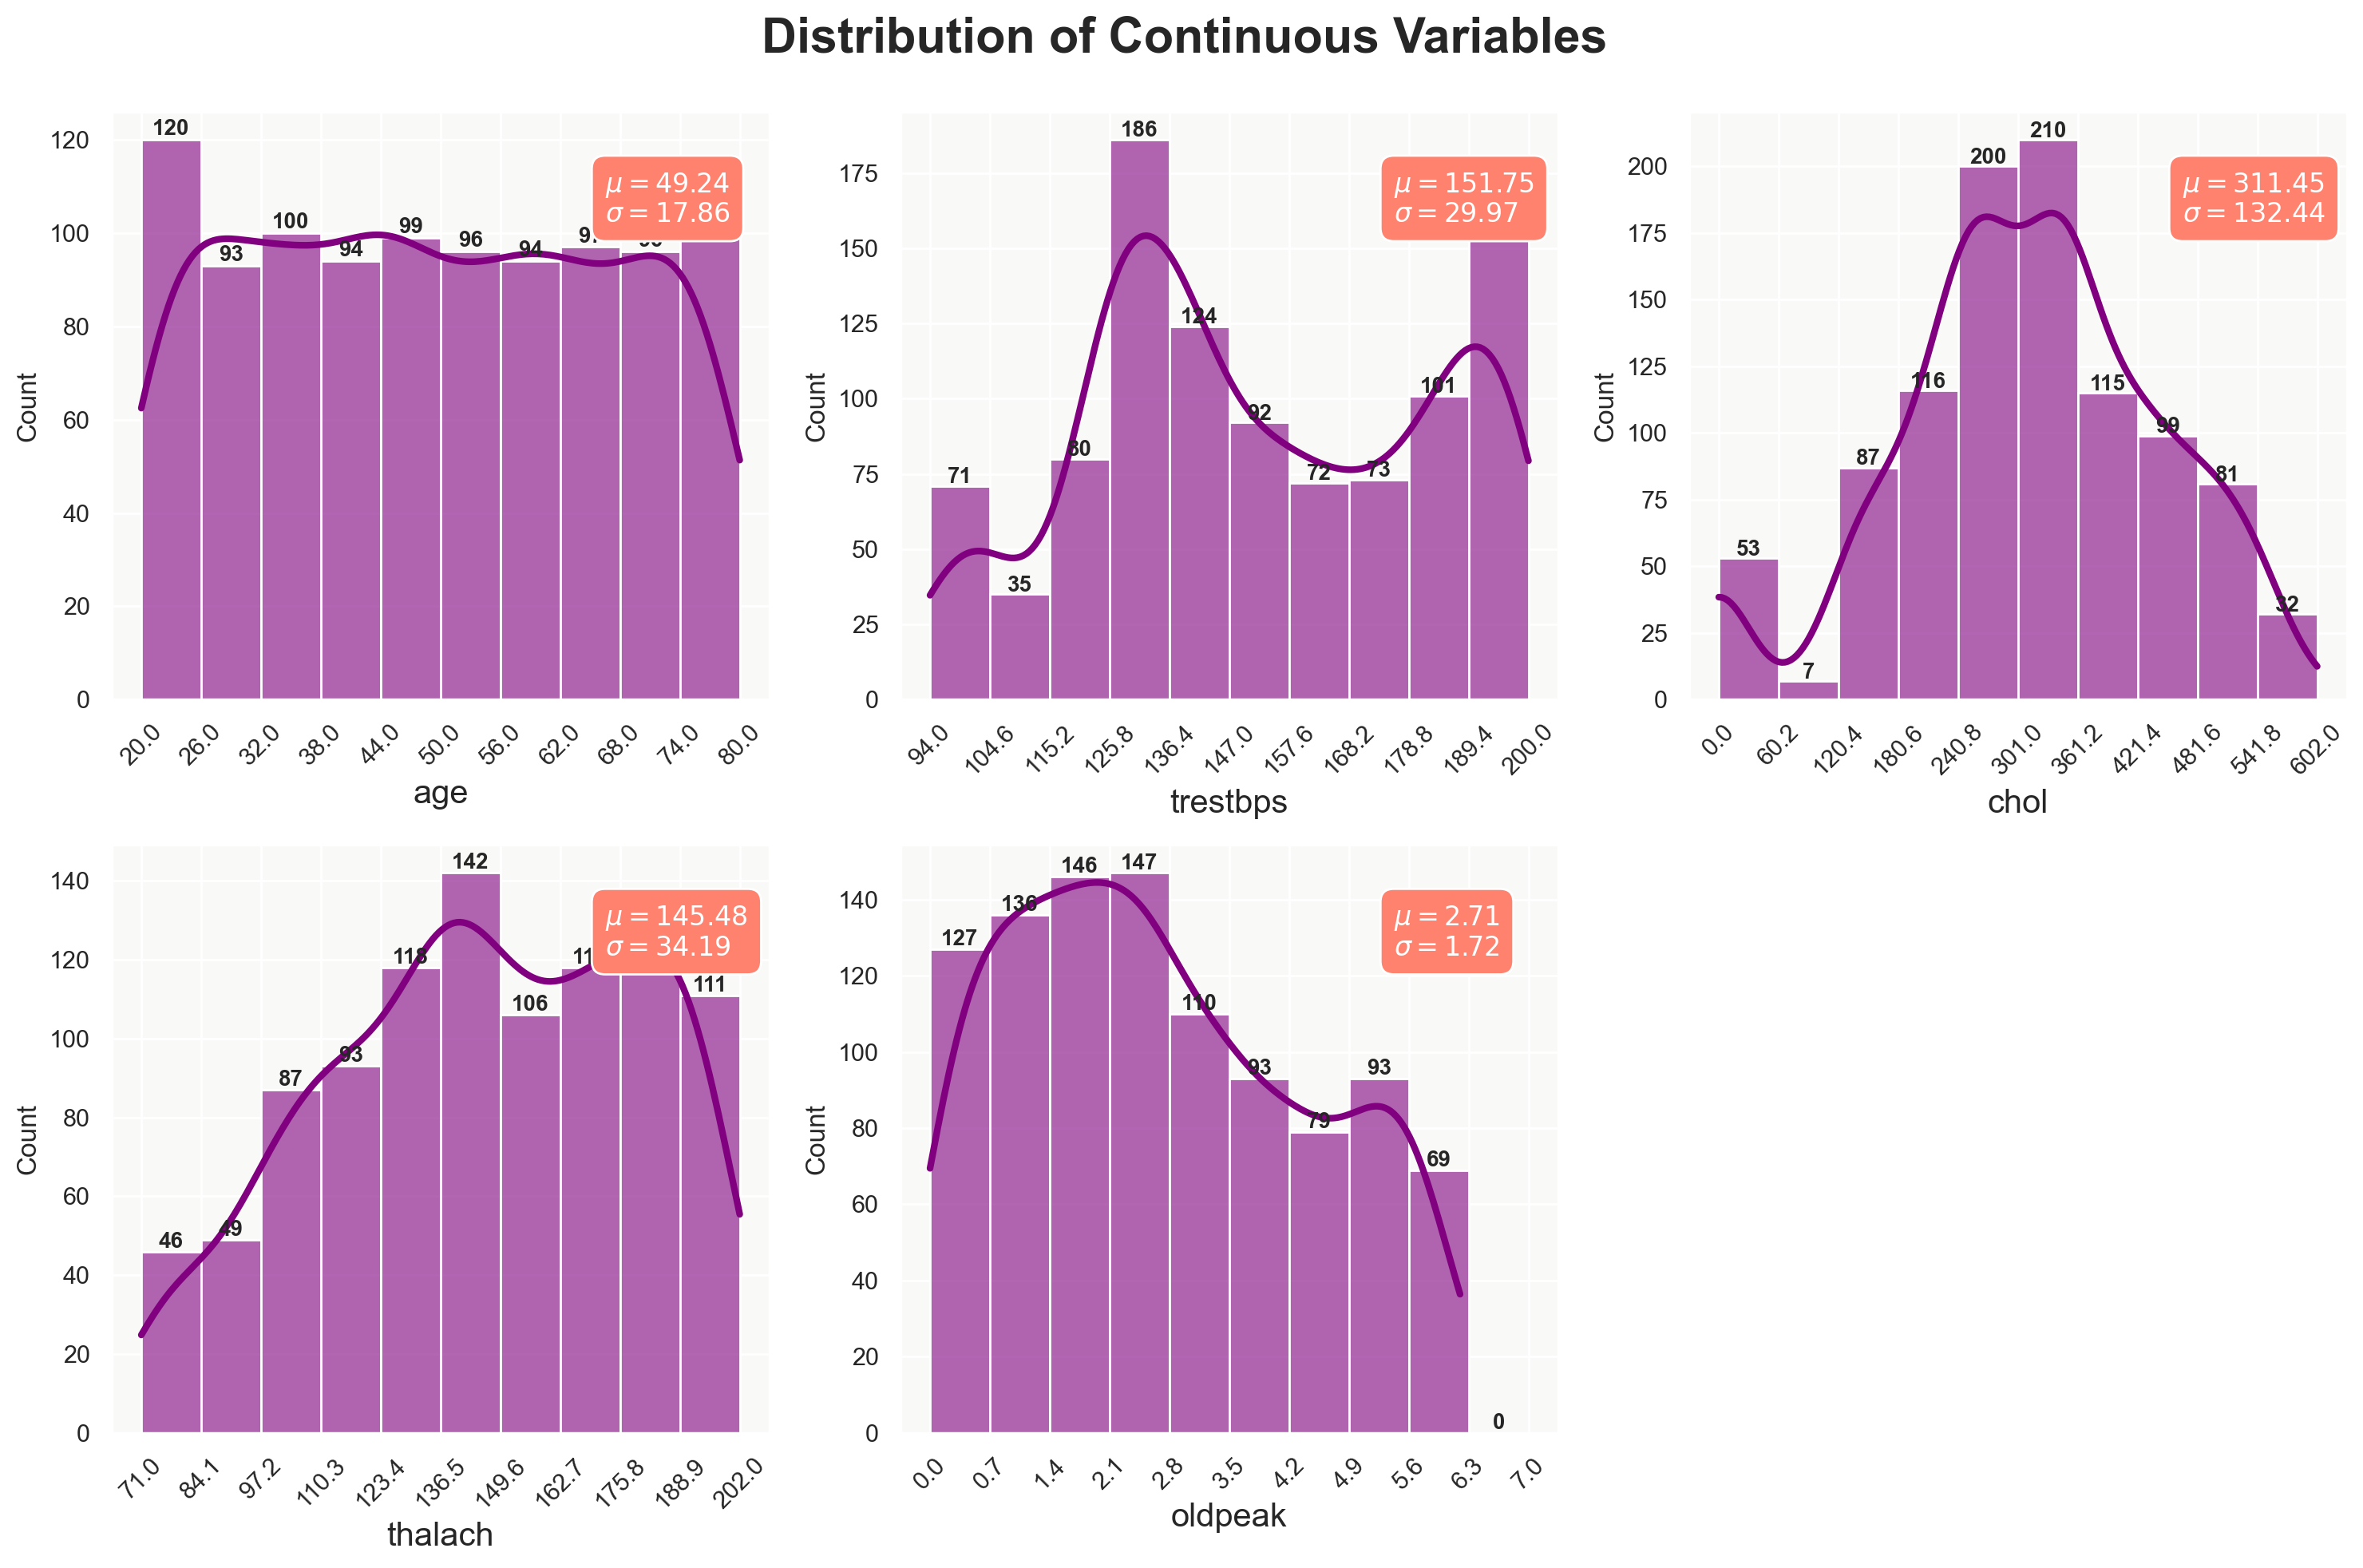

In [8]:
df_continuous = df[continuous_features]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                        range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='white', color='purple', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='white')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables',weight='bold' ,fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### UNIVARIATE ANALYSIS OF CATEGORICAL FEATURES

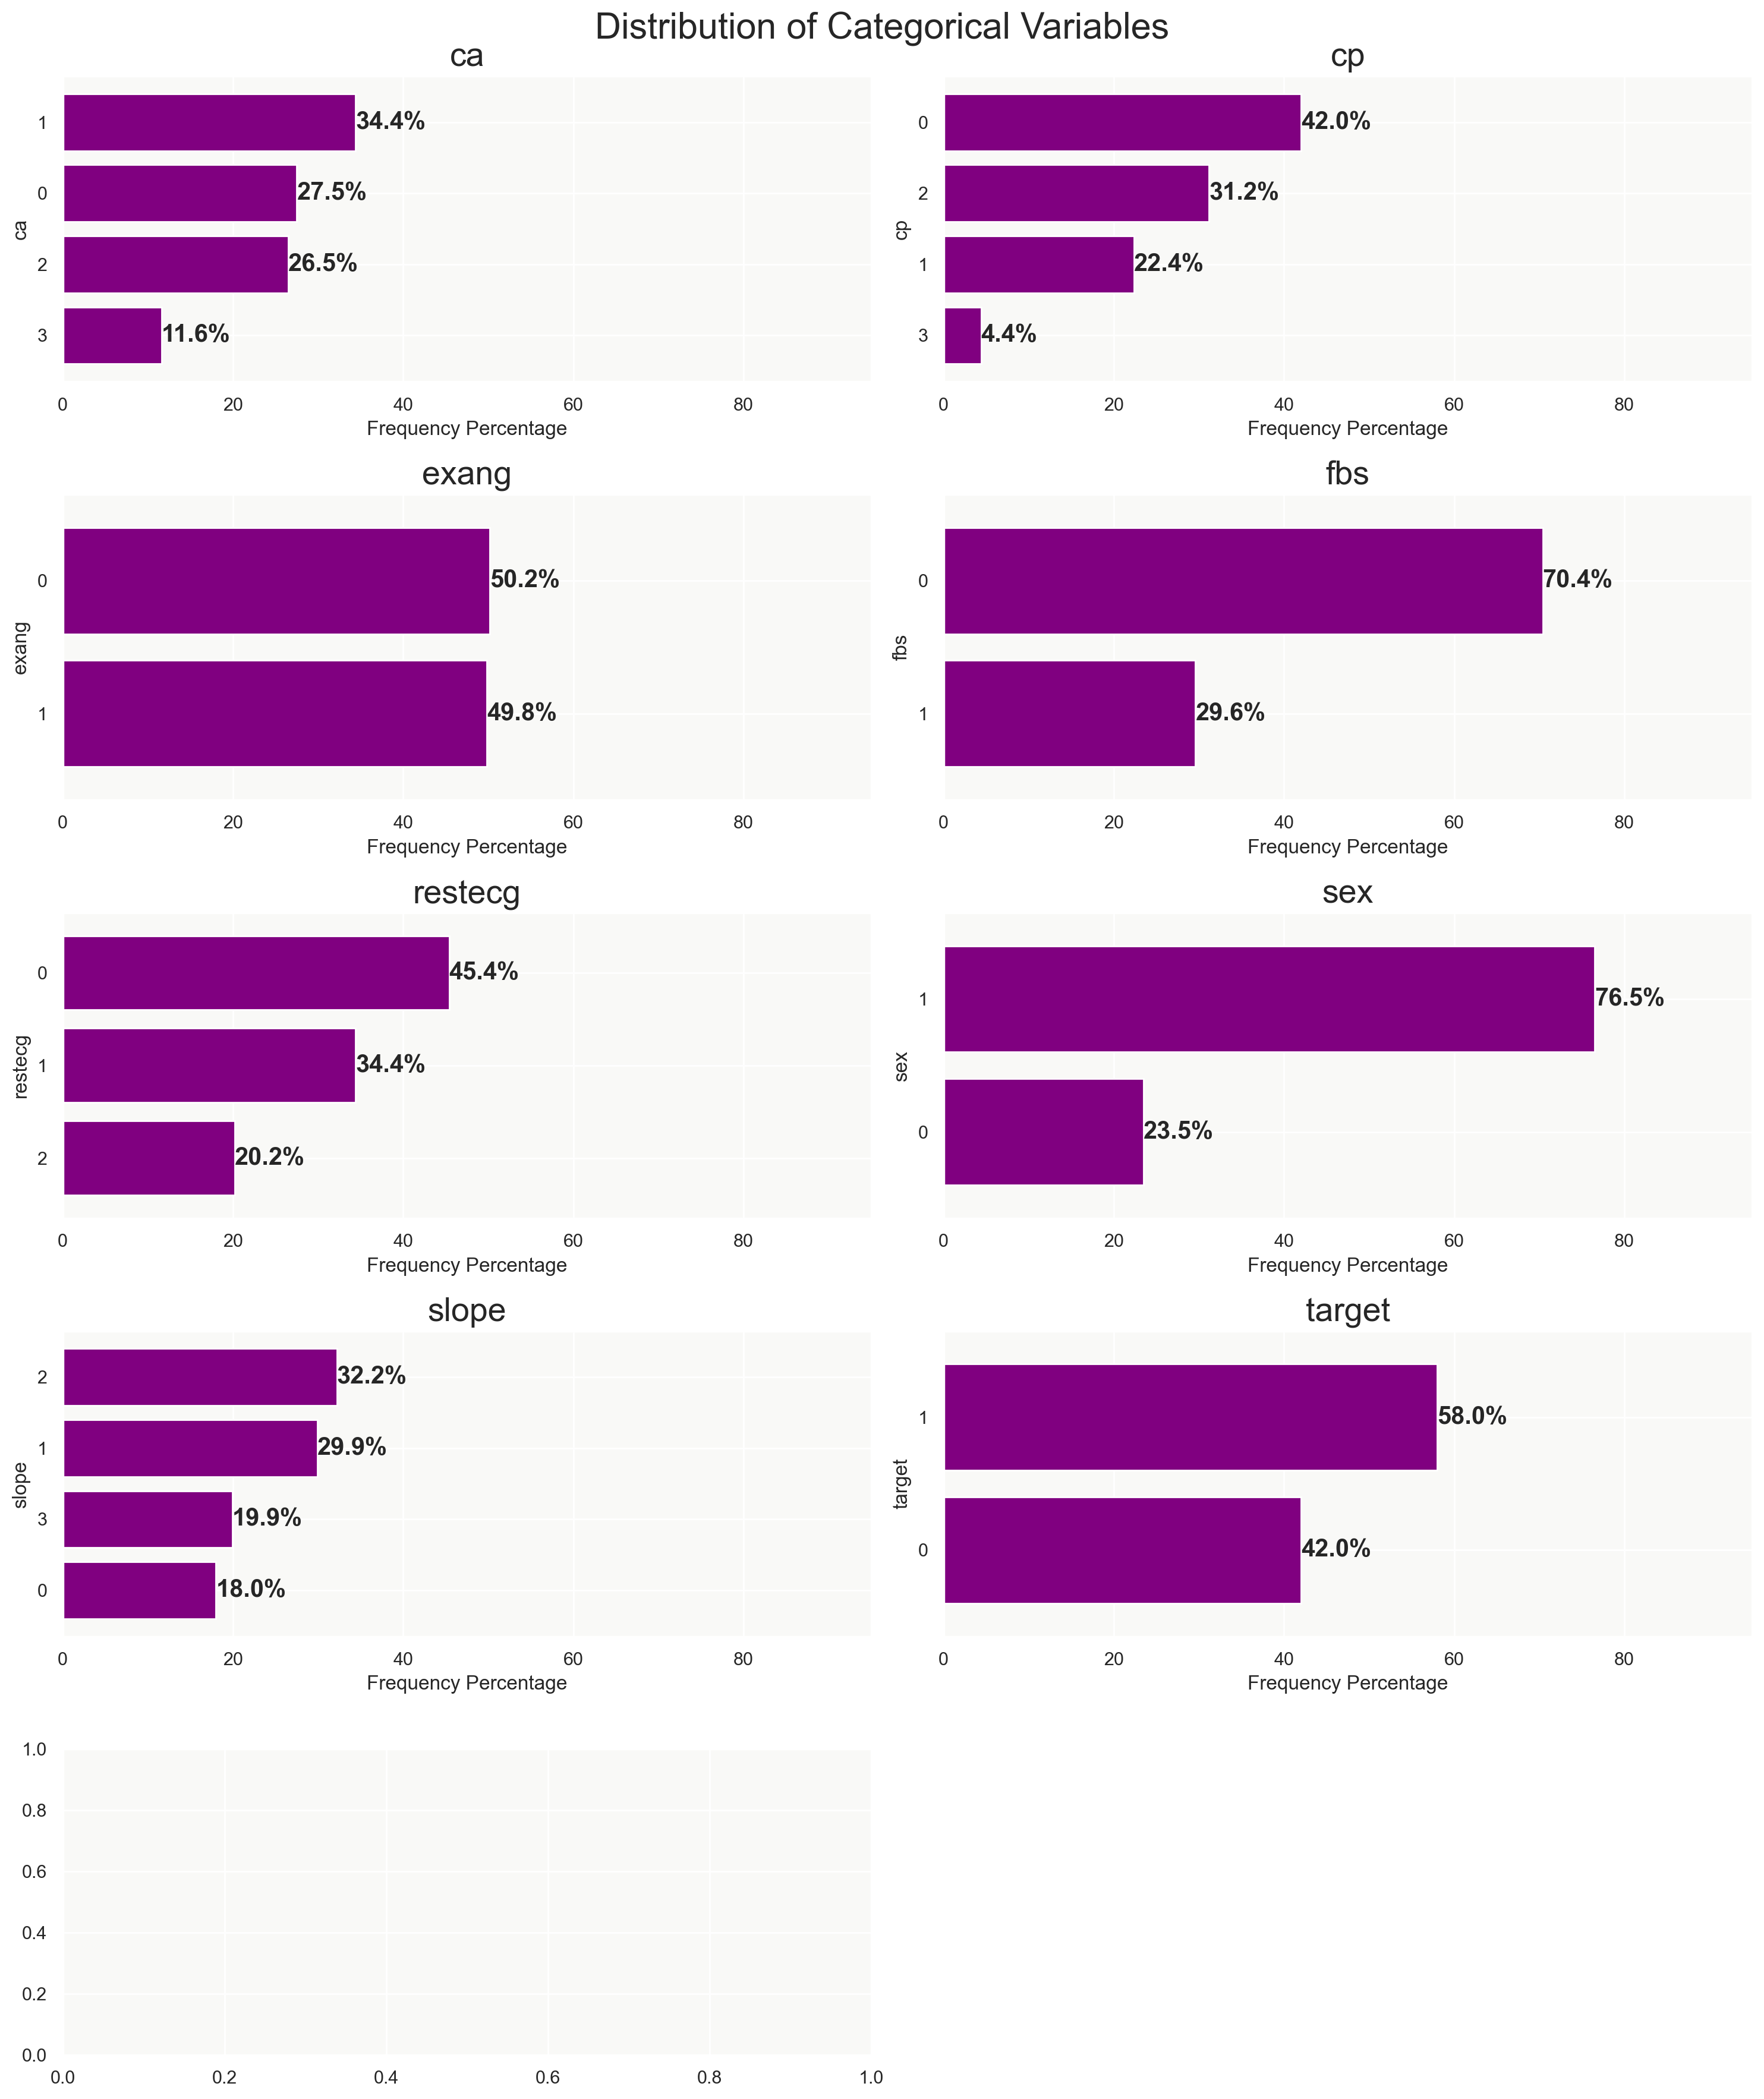

In [9]:
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='purple')
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)
ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### CONTINUOUS FEATURES VS TARGET DISTRIBUTION [ i.e. PRESENCE OF HEART DISEASE ]

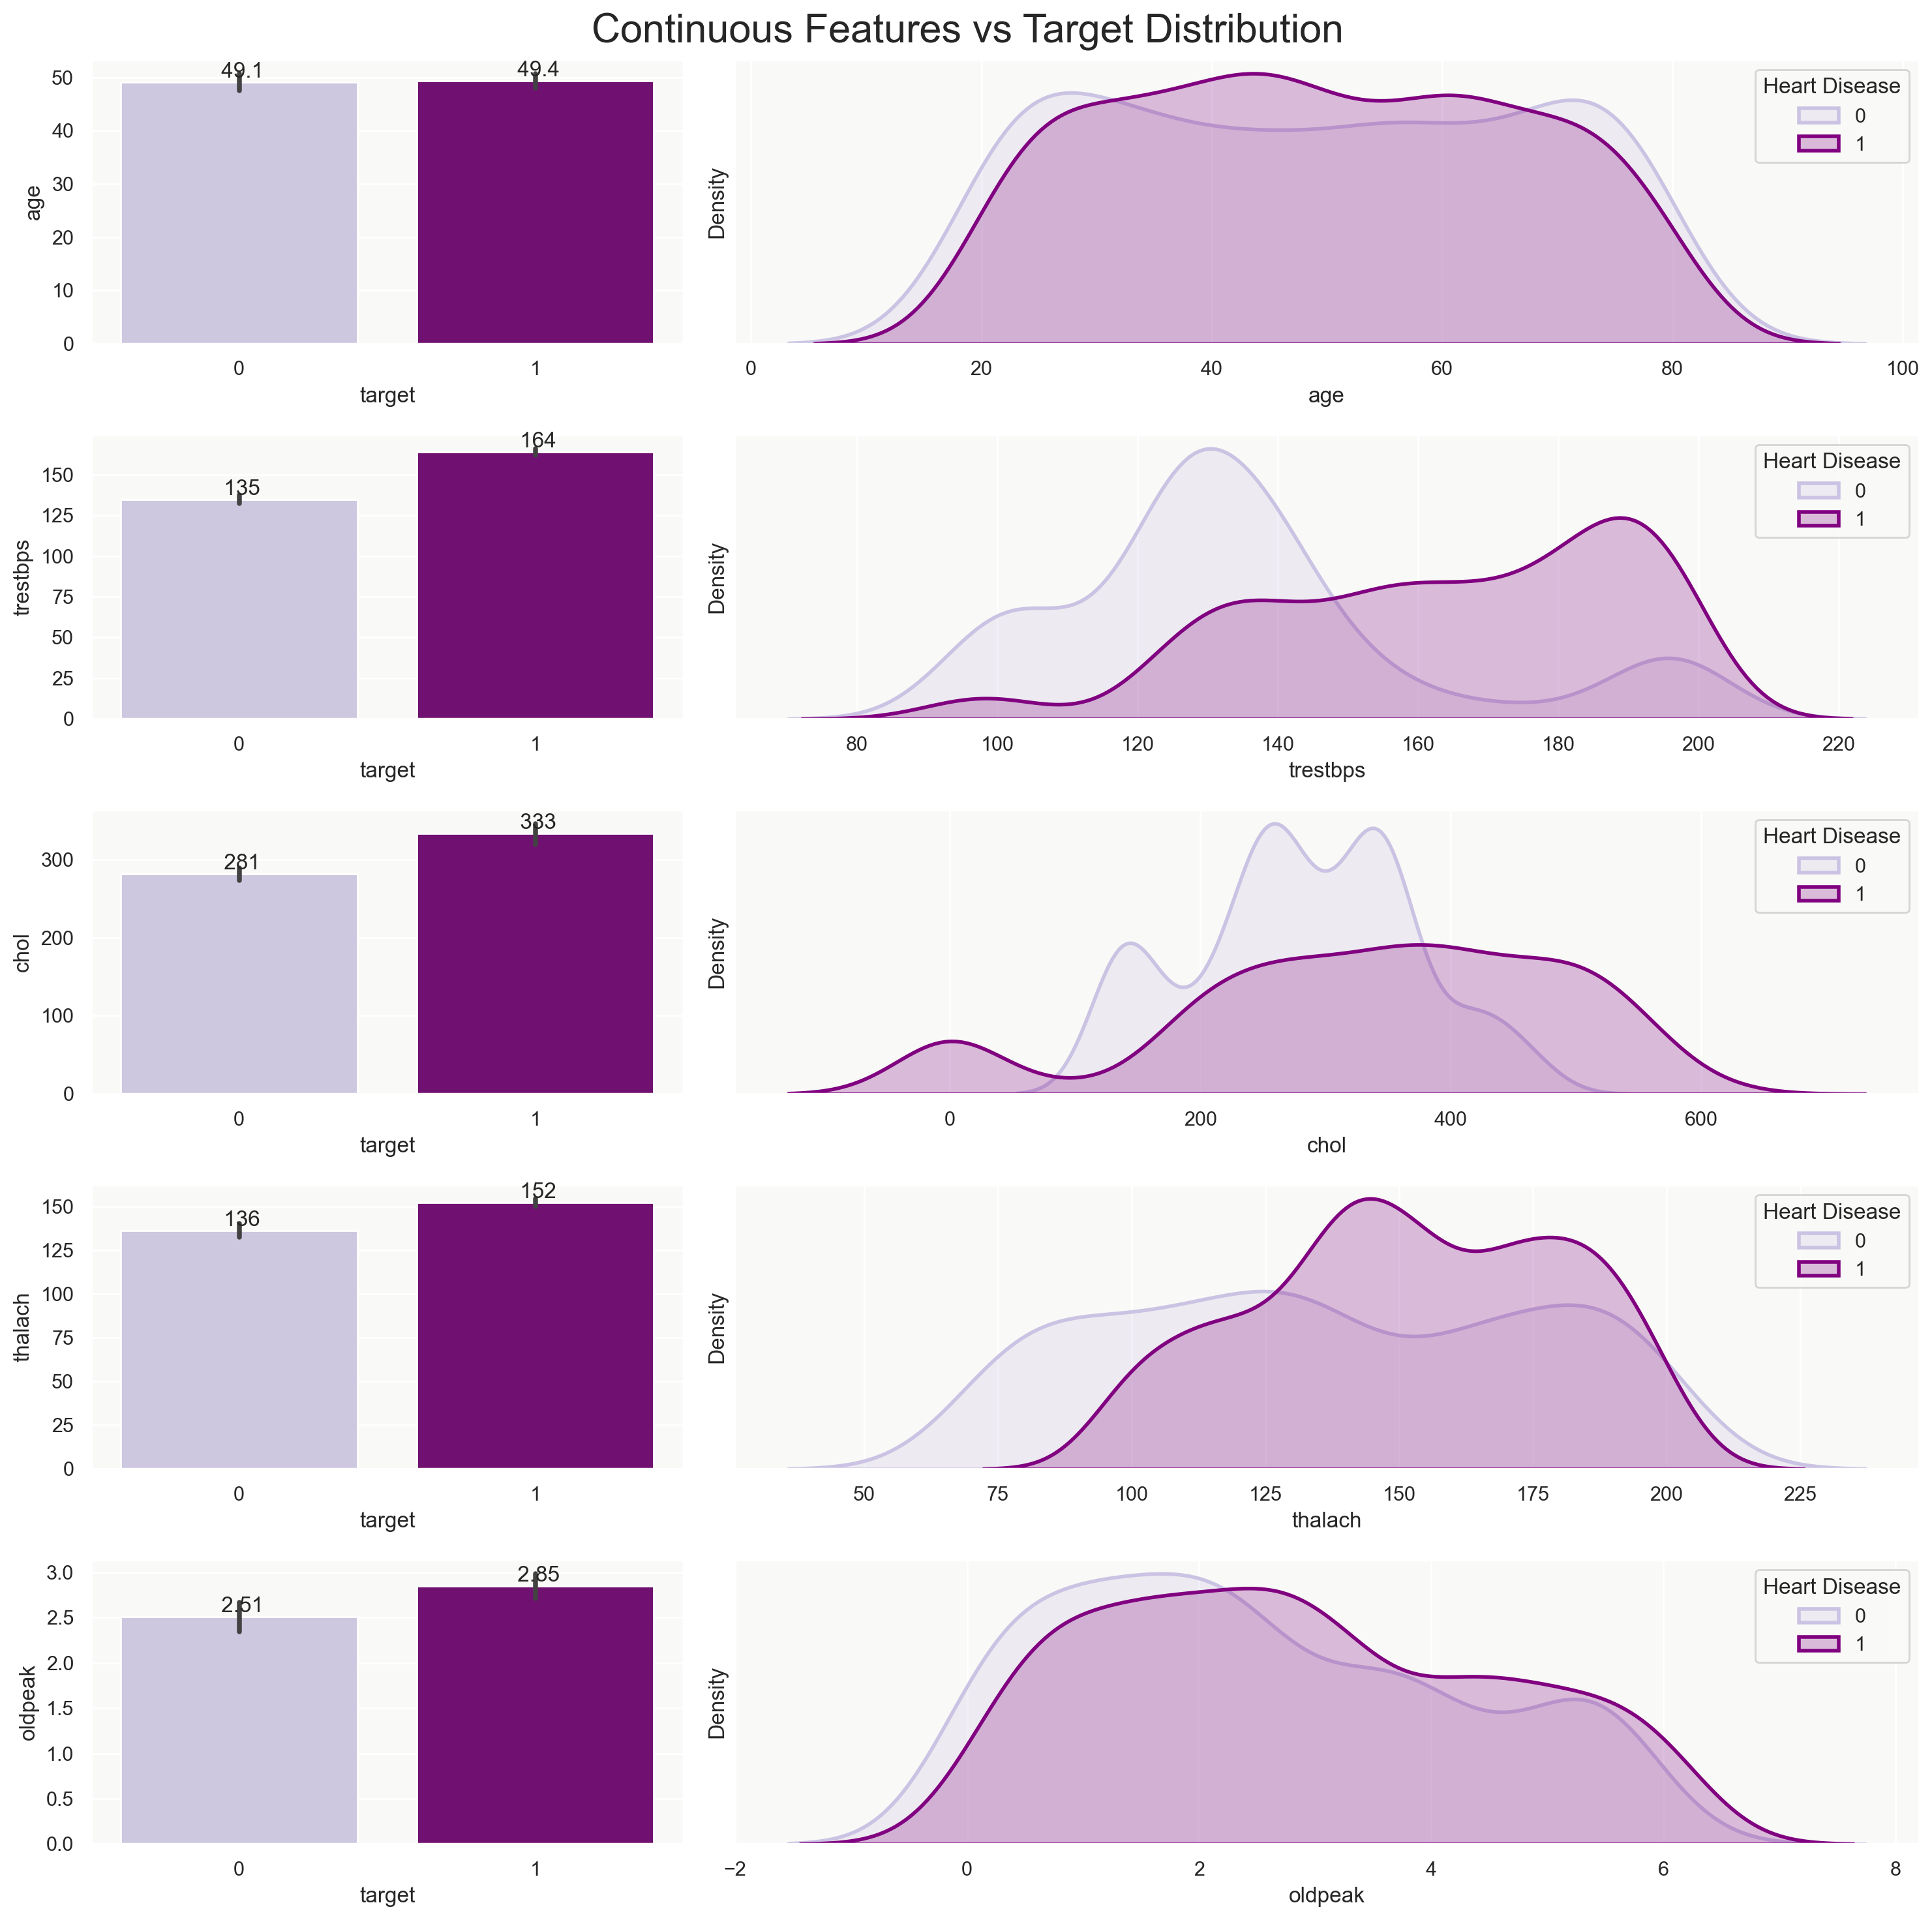

In [10]:
sns.set_palette(['#CBC3E3', 'purple'])
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})
for i, col in enumerate(continuous_features):
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    for cont in graph.containers:
        graph.bar_label(cont, fmt=' %.3g')
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

### CATEGORICAL FEATURES VS TARGET 

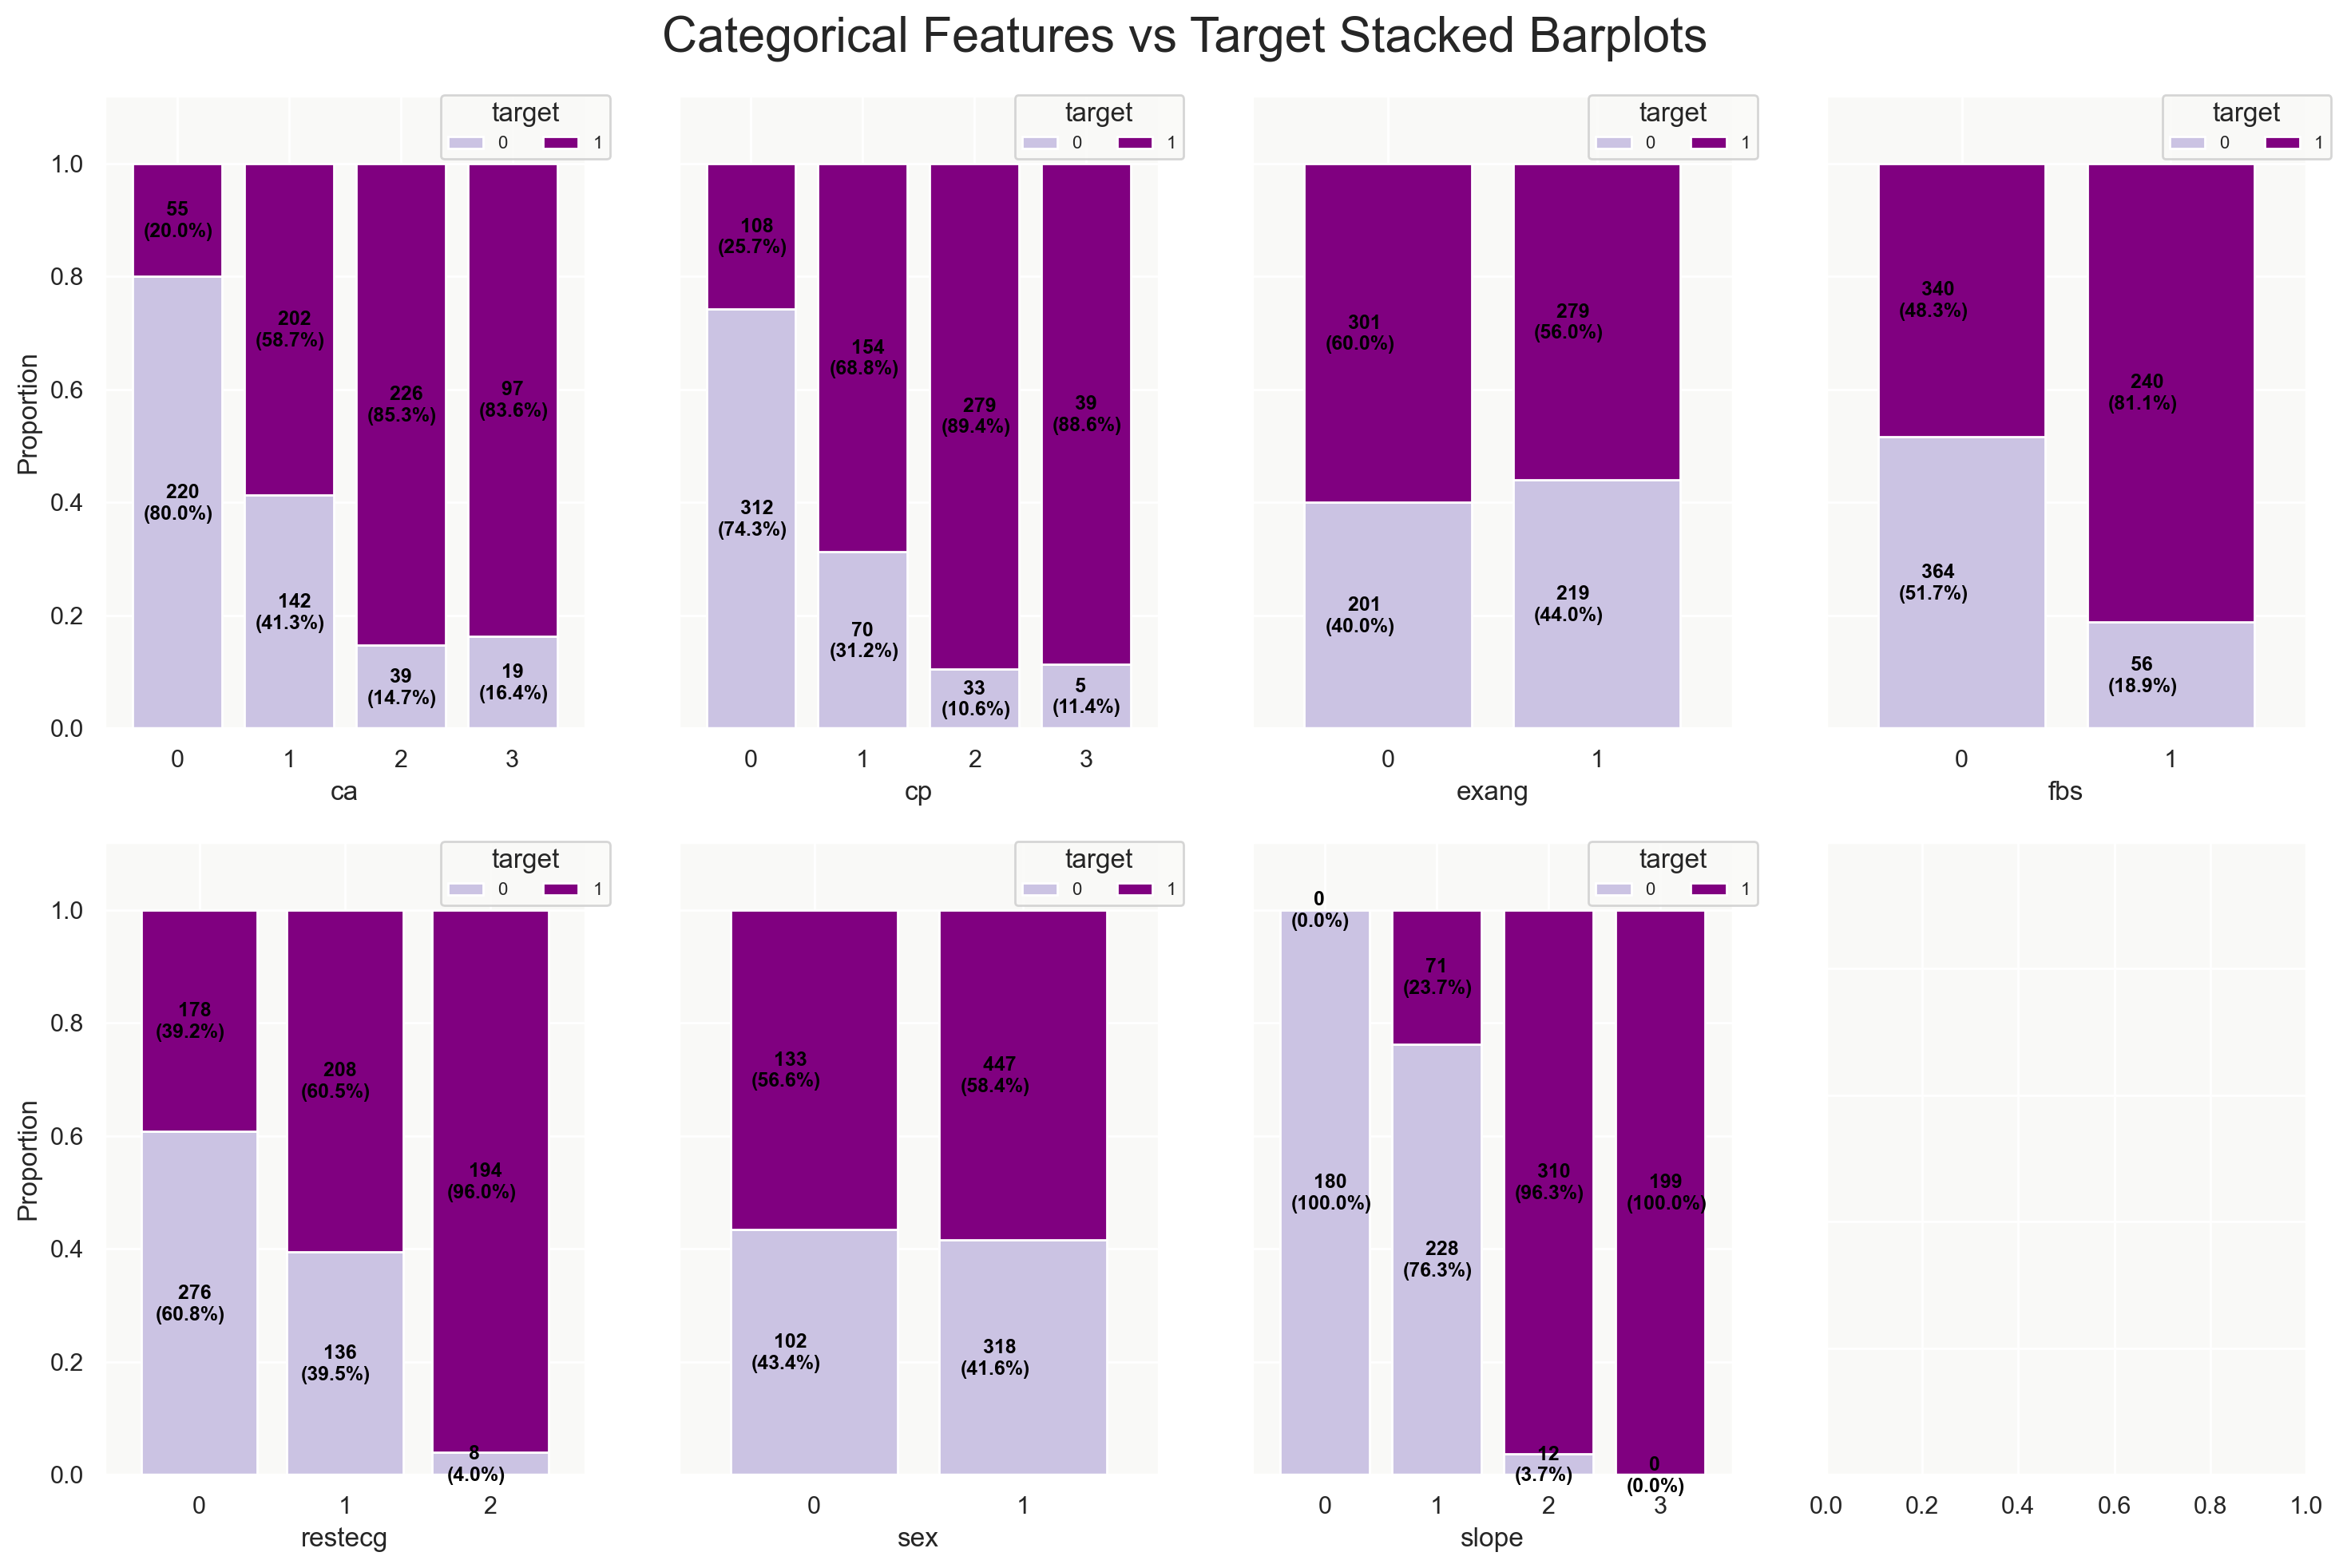

In [11]:
categorical_features = [feature for feature in categorical_features if feature != 'target']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i,col in enumerate(categorical_features):
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')
    cmp = ListedColormap(['#CBC3E3', 'purple'])
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    ax[x,y].set_ylim([0,1.12])
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

In [12]:
df.isnull().sum().sum()

0

In [13]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [14]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()
outliers_count_specified

age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
dtype: int64

### USING ONE HOT ENCODING ON FEW AND THE REST IS CONVERTED TO INTEGER 
### [ DONE ON CATEGORICAL DATA ]

In [15]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg'], drop_first=True)
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)
df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
dtype: object

### DATAFRAME AFTER ALL THE ALTERATIONS 

In [16]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2
0,53,1,171,0,0,147,0,5.3,3,3,1,False,True,False,True,False
1,40,1,94,229,0,115,0,3.7,1,1,0,False,False,False,True,False
2,49,1,133,142,0,202,1,5.0,1,0,0,False,True,False,False,False
3,43,1,138,295,1,153,0,3.2,2,2,1,False,False,False,True,False
4,31,1,199,0,0,136,0,5.3,3,2,1,True,False,False,False,True


### SPLITING DATA FOR TEST AND TRAIN 

In [17]:
X = df_encoded.drop('target', axis=1)
Y = df_encoded['target'] 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [18]:
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

In [19]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2
2,49,1,133,142,0,202,1,5.001,1,0,False,True,False,False,False
147,37,0,124,310,1,160,1,0.201,2,0,False,True,False,False,True
25,71,1,101,352,0,183,0,3.601,0,0,True,False,False,True,False
186,20,1,156,354,0,197,1,2.101,3,1,False,False,False,False,False
430,26,0,131,559,0,131,1,2.601,3,3,False,True,False,False,True


###  HYPERPARAMETER TUNING


In [20]:
def tune_clf_hyperparameters(clf, param_grid, X_train, Y_train, scoring='recall', n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    clf_grid.fit(X_train, Y_train)
    best_hyperparameters = clf_grid.best_params_
    return clf_grid.best_estimator_, best_hyperparameters

###  Fn TO EVALUATE THE MODEL BASED ON -->  PRECISION , RECALL , F1 

In [21]:
def evaluate_model(model, X_test, Y_test, model_name):
    Y_pred = model.predict(X_test)
    report = classification_report(Y_test, Y_pred, output_dict=True)
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(Y_test, Y_pred)
    }
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    return df

# DESICION TREE

In [22]:
dt_base = DecisionTreeClassifier(random_state=0)

In [23]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [24]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, Y_train)

In [25]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [26]:
print(classification_report(Y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       294
           1       0.94      0.98      0.96       406

    accuracy                           0.95       700
   macro avg       0.95      0.94      0.95       700
weighted avg       0.95      0.95      0.95       700



In [27]:
dt_evaluation = evaluate_model(best_dt, X_test, Y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.95,0.93,0.9,0.97,0.92,0.95,0.94,0.93,0.93,0.94


### RANDOM FOREST

In [28]:
rf_base = RandomForestClassifier(random_state=0)
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, Y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [29]:
print(classification_report(Y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       294
           1       0.96      0.97      0.96       406

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700



In [30]:
print(classification_report(Y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       126
           1       0.94      0.95      0.95       174

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.93       300
weighted avg       0.94      0.94      0.94       300



In [31]:
rf_evaluation = evaluate_model(best_rf, X_test, Y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.93,0.94,0.91,0.95,0.92,0.95,0.94,0.93,0.93,0.94


# KNN - [ K NEAREST NEIGHBOUR ]

In [32]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, Y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}


In [33]:
print(classification_report(Y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       1.00      1.00      1.00       406

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



In [34]:
print(classification_report(Y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       126
           1       0.95      0.93      0.94       174

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [35]:
knn_evaluation = evaluate_model(best_knn, X_test, Y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.9,0.95,0.94,0.93,0.92,0.94,0.93,0.93,0.93,0.93


#  SVM - [SUPPORT VECTOR MACHINE]

In [36]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [37]:
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, Y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [38]:
print(classification_report(Y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       294
           1       0.58      1.00      0.73       406

    accuracy                           0.58       700
   macro avg       0.29      0.50      0.37       700
weighted avg       0.34      0.58      0.43       700



In [39]:
print(classification_report(Y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.58      1.00      0.73       174

    accuracy                           0.58       300
   macro avg       0.29      0.50      0.37       300
weighted avg       0.34      0.58      0.43       300



In [40]:
svm_evaluation = evaluate_model(best_svm, X_test, Y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.0,0.58,0.0,1.0,0.0,0.73,0.29,0.5,0.37,0.58


###  FINAL VALUES OF ALL THE ALGORITHMS 

In [41]:
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.00,0.58,0.00,1.00,0.00,0.73,0.29,0.50,0.37,0.58
DT,0.95,0.93,0.90,0.97,0.92,0.95,0.94,0.93,0.93,0.94
RF,0.93,0.94,0.91,0.95,0.92,0.95,0.94,0.93,0.93,0.94
KNN,0.90,0.95,0.94,0.93,0.92,0.94,0.93,0.93,0.93,0.93


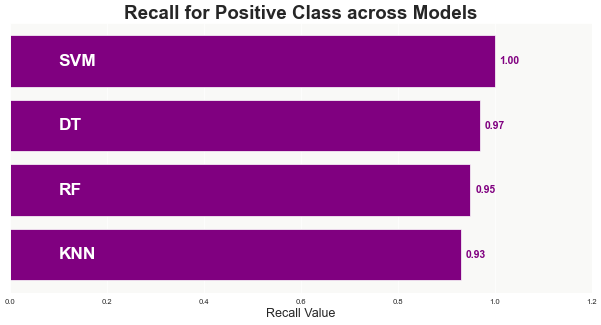

In [42]:
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']
fig, ax = plt.subplots(figsize=(15, 7), dpi=50)
ax.barh(results.index, recall_1_scores, color='purple')
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='purple', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)
ax.set_yticks([])
ax.set_xlim([0, 1.2])
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=27)
plt.xlabel('Recall Value', fontsize=18)
plt.show()

In [43]:
X_train.head(5)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2
2,49,1,133,142,0,202,1,5.001,1,0,False,True,False,False,False
147,37,0,124,310,1,160,1,0.201,2,0,False,True,False,False,True
25,71,1,101,352,0,183,0,3.601,0,0,True,False,False,True,False
186,20,1,156,354,0,197,1,2.101,3,1,False,False,False,False,False
430,26,0,131,559,0,131,1,2.601,3,3,False,True,False,False,True


In [44]:
df_encoded

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2
0,53,1,171,0,0,147,0,5.3,3,3,1,False,True,False,True,False
1,40,1,94,229,0,115,0,3.7,1,1,0,False,False,False,True,False
2,49,1,133,142,0,202,1,5.0,1,0,0,False,True,False,False,False
3,43,1,138,295,1,153,0,3.2,2,2,1,False,False,False,True,False
4,31,1,199,0,0,136,0,5.3,3,2,1,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,1,139,349,0,183,1,5.6,2,2,1,False,True,False,False,True
996,47,1,143,258,1,98,1,5.7,1,0,0,False,False,True,True,False
997,69,1,156,434,1,196,0,1.4,3,1,1,False,False,False,False,False
998,45,1,186,417,0,117,1,5.9,3,2,1,True,False,False,True,False


In [50]:
import tkinter
from tkinter import ttk, filedialog, messagebox
import os
import openpyxl
import numpy as np
import pandas as pd  # Add missing import

def process_data(file_path):
    if file_path:
        try:
            global ndf 
            ndf= pd.read_excel(file_path)
            print(ndf.head())
        except Exception as e:
            print("Error reading Excel file:", e)

def predict_individual_data():
    firstname = first_name_entry.get()
    lastname = last_name_entry.get()
    
    if firstname and lastname:
        # Extract data from GUI widgets
        age = int(age_spinbox.get())
        sex_m = gender_combobox.get()
        sex = int(sex_m[0])
        cp_m = cp_combobox.get()
        cp = int(cp_m[0])
        bp = int(bp_spinbox.get())
        chol = int(chol_spinbox.get())
        restecg_m = restecg_combobox.get()
        restecg = int(restecg_m[0])
        thalach = int(thalach_spinbox.get())
        exang_m = exang_combobox.get()
        exang = int(exang_m[0])
        oldpeak = float(oldpeak_spinbox.get())
        slope_m = slope_combobox.get()
        slope = int(slope_m[0])
        ca = int(ca_spinbox.get())
        
        if bp <= 120:
            fbs = 0
        else:
            fbs = 1
            
        if cp == 0:
            cp_1, cp_2, cp_3 = 0, 0, 0
        elif cp == 1:
            cp_1, cp_2, cp_3 = 1, 0, 0
        elif cp == 2:
            cp_1, cp_2, cp_3 = 0, 1, 0
        elif cp == 3:
            cp_1, cp_2, cp_3 = 0, 0, 1
            
        if restecg == 0:
            restecg_1, restecg_2 = 0, 0
        elif restecg == 1:
            restecg_1, restecg_2 = 1, 0
        elif restecg == 2:
            restecg_1, restecg_2 = 0, 1

        input_data = np.array([age, sex, bp, chol, fbs, thalach, exang, oldpeak, slope, ca, cp_1, cp_2, cp_3, restecg_1, restecg_2])

        try:
            lst1 = list(best_dt.predict([input_data]))
            lst2 = list(best_knn.predict([input_data]))
            lst3 = list(best_rf.predict([input_data]))
            lst4 = list(best_svm.predict([input_data]))
            prediction = []
            for i in range(len(lst1)):
                c0 = lst1[i] + lst2[i] + lst3[i] + lst4[i]
                c1 = (4 - c0)
                if c0 < c1:
                    prediction.append(0)
                else:
                    prediction.append(1)
            if prediction[0] == 0:
                tkinter.messagebox.showinfo("Prediction", f"{firstname} does not have any heart disease.")
                target = 0
            else:
                tkinter.messagebox.showinfo("Prediction", f"{firstname} has a heart disease.")
                target = 1
                
        except Exception as e:
            tkinter.messagebox.showerror("Prediction Error", f"An error occurred during prediction: {str(e)}")
            print("Error during prediction:", e)
        
        # Save data to Excel file
        save_data_to_excel(firstname, lastname, age, sex_m, cp_m, bp, chol, restecg_m, thalach, exang_m, oldpeak, slope_m, ca, target)
    else:
        tkinter.messagebox.showwarning("Error", "First name and last name are required.")

def save_data_to_excel(firstname, lastname, age, sex, cp, bp, chol, restecg, thalach, exang, oldpeak, slope, ca, target):
    directory = "C:\\Users\\Hp\\Tkinter Data Entry\\"
    filename = "individual_data.xlsx"
    filepath = os.path.join(directory, filename)
    
    try:
        os.makedirs(directory, exist_ok=True)
        
        if not os.path.exists(filepath):
            workbook = openpyxl.Workbook()
            sheet = workbook.active
            heading = ["First Name", "Last Name", "Age", "Gender",
                       "Chest Pain", "Blood Pressure", "Cholesterol",
                       "Resting Electrocardiographic Result", "Heart Rate",
                       "Exercise Induced", "Old Peak", "Slope", "Number of Major Vessels", "Target"]
            sheet.append(heading)
            workbook.save(filepath)
        
        workbook = openpyxl.load_workbook(filepath)
        sheet = workbook.active
        sheet.append([firstname, lastname, age, sex, cp, bp, chol, restecg, thalach, exang, oldpeak, slope, ca, target])
        workbook.save(filepath)
    except Exception as e:
        tkinter.messagebox.showerror("File Save Error", f"An error occurred while saving data to Excel: {str(e)}")
        print("Error saving data to Excel:", e)

def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", ".xlsx"), ("All files", ".*")])
    if file_path:
        file_path_entry.delete(0, tkinter.END)
        file_path_entry.insert(tkinter.END, file_path)

def process_selected_file():
    file_path = file_path_entry.get()
    if file_path:
        process_data(file_path)
    else:
        messagebox.showwarning("Error", "Please select a file first.")

window = tkinter.Tk()
window.title("Heart Disease Prediction ")

frame = tkinter.Frame(window)
frame.pack()

# Option 1: Upload Excel file and process data
file_frame = tkinter.LabelFrame(frame, text="Process Data from Excel File")
file_frame.grid(row=0, column=0, padx=20, pady=10, sticky="ew")

file_path_label = tkinter.Label(file_frame, text="File Path:")
file_path_label.grid(row=0, column=0, padx=5, pady=5)

file_path_entry = tkinter.Entry(file_frame, width=50)
file_path_entry.grid(row=0, column=1, padx=5, pady=5)

browse_button = tkinter.Button(file_frame, text="Browse", command=select_file)
browse_button.grid(row=0, column=2, padx=5, pady=5)

process_button = tkinter.Button(file_frame, text="Process File", command=process_selected_file)
process_button.grid(row=1, column=1, padx=5, pady=5)

# Option 2: Add individual data and predict heart disease
individual_frame = tkinter.LabelFrame(frame, text="Predict Individual Data")

user_info_frame = tkinter.LabelFrame(individual_frame, text="User Information")
user_info_frame.grid(row=0, column=0, padx=20, pady=10)

first_name_label = tkinter.Label(user_info_frame, text="First Name:")
first_name_label.grid(row=0, column=0, padx=5, pady=5)

first_name_entry = tkinter.Entry(user_info_frame)
first_name_entry.grid(row=0, column=1, padx=5, pady=5)

last_name_label = tkinter.Label(user_info_frame, text="Last Name:")
last_name_label.grid(row=0, column=2, padx=5, pady=5)

last_name_entry = tkinter.Entry(user_info_frame)
last_name_entry.grid(row=0, column=3, padx=5, pady=5)

gender_label = tkinter.Label(user_info_frame, text="Gender:")
gender_label.grid(row=0, column=4, padx=5, pady=5)

gender_combobox = ttk.Combobox(user_info_frame, values=["0:Male", "1:Female"])
gender_combobox.grid(row=0, column=5, padx=5, pady=5)

age_label = tkinter.Label(user_info_frame, text="Age:")
age_label.grid(row=1, column=0, padx=5, pady=5)

age_spinbox = tkinter.Spinbox(user_info_frame, from_=18, to=110)
age_spinbox.grid(row=1, column=1, padx=5, pady=5)

cp_label = tkinter.Label(user_info_frame, text="Chest Pain")
cp_combobox = ttk.Combobox(user_info_frame, values=["0: Typical angina","1: Atypical angina","2: Non-anginal pain","3: Asymptomatic"])
cp_label.grid(row=1, column=2, padx=5, pady=5)
cp_combobox.grid(row=1, column=3, padx=5, pady=5)

bp_label = tkinter.Label(user_info_frame, text="Blood Pressure")
bp_spinbox = tkinter.Spinbox(user_info_frame, from_=0, to=500)
bp_label.grid(row=1, column=4, padx=5, pady=5)
bp_spinbox.grid(row=1, column=5, padx=5, pady=5)

chol_label = tkinter.Label(user_info_frame, text="Cholestrol")
chol_spinbox = tkinter.Spinbox(user_info_frame, from_=0, to=500)
chol_label.grid(row=2, column=0, padx=5, pady=5)
chol_spinbox.grid(row=2, column=1, padx=5, pady=5)

restecg_label = tkinter.Label(user_info_frame, text="Electrocaliographic Result")
restecg_combobox = ttk.Combobox(user_info_frame, values=["0: Normal","1: Having ST-T wave abnormality","2: Showing probable or definite left ventricular hypertrophy"])
restecg_label.grid(row=2, column=2, padx=5, pady=5)
restecg_combobox.grid(row=2, column=3, padx=5, pady=5)

thalach_label = tkinter.Label(user_info_frame, text="Heart Rate")
thalach_spinbox = tkinter.Spinbox(user_info_frame, from_=0, to=1000)
thalach_label.grid(row=2, column=4, padx=5, pady=5)
thalach_spinbox.grid(row=2, column=5, padx=5, pady=5)

exang_label = tkinter.Label(user_info_frame, text="Exercise Induced")
exang_combobox = ttk.Combobox(user_info_frame, values=["1: Yes","2: No"])
exang_label.grid(row=3, column=0, padx=5, pady=5)
exang_combobox.grid(row=3, column=1, padx=5, pady=5)

oldpeak_label = tkinter.Label(user_info_frame, text="Old Peak")
oldpeak_spinbox = tkinter.Spinbox(user_info_frame, from_=0.0, to=5.0, increment=0.1)
oldpeak_label.grid(row=3, column=2, padx=5, pady=5)
oldpeak_spinbox.grid(row=3, column=3, padx=5, pady=5)

slope_label = tkinter.Label(user_info_frame, text="Slope of the peak exercise")
slope_combobox = ttk.Combobox(user_info_frame, values=["0: Upsloping","1: Flat","2: Downsloping"])
slope_label.grid(row=3, column=4, padx=5, pady=5)
slope_combobox.grid(row=3, column=5, padx=5, pady=5)

ca_label = tkinter.Label(user_info_frame, text="Number of major vessels")
ca_spinbox = tkinter.Spinbox(user_info_frame, from_=0, to=4)
ca_label.grid(row=4, column=0, padx=5, pady=5)
ca_spinbox.grid(row=4, column=1, padx=5, pady=5)

thal_label = tkinter.Label(user_info_frame, text="Thalium Rate")
thal_spinbox = tkinter.Spinbox(user_info_frame, from_=0, to=5)
thal_label.grid(row=4, column=4, padx=5, pady=5)
thal_spinbox.grid(row=4, column=5, padx=5, pady=5)

for widget in user_info_frame.winfo_children():
    widget.grid_configure(padx=10, pady=5)

# Button to predict heart disease for individual data
predict_button = tkinter.Button(individual_frame, text="Predict", command=predict_individual_data)
predict_button.grid(row=1, column=0, padx=20, pady=10)

# Option menu for selecting the operation mode
def option_selected(*args):
    selected_option = option_variable.get()
    if selected_option == "Process Data from Excel File":
        file_frame.grid(row=0, column=0, padx=20, pady=10, sticky="ew")
        individual_frame.grid_remove()
    elif selected_option == "Predict Individual Data":
        file_frame.grid_remove()
        individual_frame.grid(row=0, column=0, padx=20, pady=10, sticky="ew")

option_variable = tkinter.StringVar()
option_variable.set("Process Data from Excel File")
option_variable.trace("w", option_selected)

option_menu = ttk.OptionMenu(frame, option_variable, "Process Data from Excel File", "Process Data from Excel File", "Predict Individual Data")
option_menu.grid(row=0, column=1, padx=20, pady=10, sticky="ew")

window.mainloop()

   patientid  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0     103368   63    1   3       145   233    1        0      150      0   
1     119250   37    1   2       130   250    0        1      187      0   
2     119372   41    0   1       130   204    0        0      172      0   
3     132514   56    1   1       120   236    0        1      178      0   
4     146211   57    0   0       120   354    0        1      163      1   

   oldpeak  slope  ca  
0      2.3      0   0  
1      3.5      0   0  
2      1.4      2   0  
3      0.8      2   0  
4      0.6      2   0  


In [51]:
ndf1=ndf.drop("patientid",axis=1)
ndf1 = pd.get_dummies(ndf1, columns=['cp','restecg'], drop_first=True)  
lst1=list(best_dt.predict(ndf1))
lst2=list(best_knn.predict(ndf1))
lst3=list(best_rf.predict(ndf1))
lst4=list(best_svm.predict(ndf1))
lst5=[]
for i in range(len(lst1)):
    c0 = lst1[i] + lst2[i] + lst3[i] + lst4[i]
    c1 = (4 - c0)
    if c0 < c1:
        lst5.append(0)
    else:
        lst5.append(1)
ndf.insert(loc=13, column='target', value=lst5)
pp=ndf.patientid[ndf["target"]==1]
pp=pd.DataFrame(pp)
pp

,patientid
2,119372
3,132514
4,146211
7,170498
8,188225
...,...
292,2892852
295,2901847
297,2923886
299,2956524
